In [1]:
# | code-summary: code -- load dependencies and data and select parameters

from compmemlearn.fitting import generate_objective_function
from compmemlearn.datasets import events_metadata, generate_trial_mask
from scipy.optimize import differential_evolution
from numba.typed import List, Dict
from numba.core import types
from numba import njit
from psifr import fr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
import os

lb = np.finfo(float).eps
ub = 1 - np.finfo(float).eps

figure_caption = """Distribution of log-likelihood scores of recall sequences exhibited by each subject in dataset under each considered model."""

section_tag = "LohnasKahanaCond4"

data_path = "../data/LohnasKahana2014.csv"
results_path = "results/"
trial_query = "condition == 4"

model_paths = [
    "compmemlearn.models.Base_CMR",
    "compmemlearn.models.Dual_ICMR",
    "compmemlearn.models.Dual_ICMR",
    "compmemlearn.models.Dual_ICMR",
    "compmemlearn.models.Dual_ICMR",
]

model_names = ["PrototypeCMR", "ICMR_2_0_0", "ICMR_2_0_1", "ICMR_2_1_0", "ICMR_2_1_1"]

free_parameters = [
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "context_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "context_sensitivity",
        "delay_drift_rate",
    ],
]
bounds = [
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
]
fixed_parameters = [
    {},
    {"feature_sensitivity": 1, "context_sensitivity": 1, "learn_first": False},
    {"feature_sensitivity": 1, "context_sensitivity": 1, "learn_first": True},
    {"feature_sensitivity": 1, "choice_sensitivity": 1, "learn_first": False},
    {"feature_sensitivity": 1, "choice_sensitivity": 1, "learn_first": True},
]

analysis_paths = ['compmemlearn.analyses.plot_spc', 'compmemlearn.analyses.plot_crp', 'compmemlearn.analyses.plot_pfr']
analysis_names = ['spc', 'crp', 'pfr']

experiment_count = 1

In [2]:
# Parameters
data_path = "data/LohnasKahana2014.csv"
trial_query = "subject > -1"
model_paths = [
    "compmemlearn.models.Base_CMR",
    "compmemlearn.models.Dual_ICMR",
    "compmemlearn.models.Dual_ICMR",
    "compmemlearn.models.Dual_ICMR",
    "compmemlearn.models.Dual_ICMR",
]
model_names = ["PrototypeCMR", "ICMR_2_0_0", "ICMR_2_0_1", "ICMR_2_1_0", "ICMR_2_1_1"]
free_parameters = [
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "context_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "context_sensitivity",
        "delay_drift_rate",
    ],
]
bounds = [
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
]
fixed_parameters = [
    {},
    {"feature_sensitivity": 1, "context_sensitivity": 1, "learn_first": False},
    {"feature_sensitivity": 1, "context_sensitivity": 1, "learn_first": True},
    {"feature_sensitivity": 1, "choice_sensitivity": 1, "learn_first": False},
    {"feature_sensitivity": 1, "choice_sensitivity": 1, "learn_first": True},
]
section_tag = "LohnasKahana2014"


In [3]:
if 'Howard' in section_tag or ('Lohnas' in section_tag and '1' not in section_tag):
    analysis_paths = ['compmemlearn.analyses.plot_flex_spc', 'compmemlearn.analyses.plot_flex_crp', 'compmemlearn.analyses.plot_flex_pfr', 'compmemlearn.analyses.plot_rpl']
    analysis_names = ['spc', 'crp', 'pfr', 'rpl']

In [4]:
#| code-summary: code -- test that specified parameters are valid
#| output: false

events = pd.read_csv(data_path)

trials, list_lengths, presentations = events_metadata(events)
trial_mask = generate_trial_mask(events, trial_query)

# import models from specified source
models = []
for i in range(len(model_paths)):
    module_name, model_name = model_paths[i].rsplit('.',1)
    module = importlib.import_module(module_name)
    models.append(getattr(module, model_name))

# import analyses from specified source
analyses = []
for i in range(len(analysis_paths)):
    module_name, analysis_name = analysis_paths[i].rsplit('.',1)
    module = importlib.import_module(module_name)
    analyses.append(getattr(module, analysis_name))

# make sure model initializes with provided parameters and boundaries
for model_index, model_class in enumerate(models):

    @njit(fastmath=True, nogil=True)
    def init_model(item_count, presentation_count, parameters):
        return model_class(item_count, presentation_count, parameters)

    subject_specific_trial_mask = np.logical_and(
                generate_trial_mask(events, f'subject == {pd.unique(events.subject)[0]}'), trial_mask)

    cost_function = generate_objective_function(
        [trials[i][subject_specific_trial_mask[i]] for i in range(len(trials))],
        [presentations[i][subject_specific_trial_mask[i]] for i in range(len(presentations))],
        list_lengths,
        init_model,
        fixed_parameters[model_index],
        free_parameters[model_index],
    )
    print(cost_function)
    
    for boundary_index in range(2):
        x = np.array([each[boundary_index] for each in bounds[model_index]])
        assert(len(x) == len(free_parameters[model_index])) 

        # parameter configuration
        parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
        for name, value in fixed_parameters[model_index].items():
            parameters[name] = value
        for i in range(len(free_parameters[model_index])):
                parameters[free_parameters[model_index][i]] = x[i]

        model = init_model(20, 20, parameters)
        model.experience(model.items)
        model.free_recall()

        print(cost_function(x))

print('dependencies and parameters validated')

<function lohnas_objective_function.<locals>.objective_function at 0x2afd30974430>


4171.165955180705
11798.446530505571


<function lohnas_objective_function.<locals>.objective_function at 0x2afd31933820>


4171.165955180705
11798.446530505571
<function lohnas_objective_function.<locals>.objective_function at 0x2afd33cc1430>


4171.165955180705
11798.446530505571
<function lohnas_objective_function.<locals>.objective_function at 0x2afd329bb430>


4171.9931738075275
11798.446530505571
<function lohnas_objective_function.<locals>.objective_function at 0x2afd33cc1940>


4171.9931738075275
11798.446530505571
dependencies and parameters validated


In [5]:
# | code-summary: code -- 1) fit each model class participant-by-participant
# | output: false

for model_index, model_class in enumerate(models):

    # load individual fits for this model and section tag from csv if they exist
    if os.path.isfile(results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index])):
        pd.read_csv(results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index]))
        print('individual fits for {} with tag {} already exist'.format(model_names[model_index], section_tag))

    # otherwise, fit each participant individually
    else:
        model_individual_fits = []

        @njit(fastmath=True, nogil=True)
        def init_model(item_count, presentation_count, parameters):
            return model_class(item_count, presentation_count, parameters)

        for subject in pd.unique(events.subject):
            print(f'{model_names[model_index]}, Subject {subject}')

            subject_specific_trial_mask = np.logical_and(
                generate_trial_mask(events, f'subject == {subject}'), trial_mask)
            
            try:
                # cost function to be minimized
                # ours scales inversely with the probability that the data could have been
                # generated using the specified parameters and our model
                cost_function = generate_objective_function(
                    [trials[i][subject_specific_trial_mask[i]] for i in range(len(trials))],
                    [presentations[i][subject_specific_trial_mask[i]] for i in range(len(presentations))],
                    list_lengths,
                    init_model,
                    fixed_parameters[model_index],
                    free_parameters[model_index],
                )
            except ValueError:
                continue

            fit_result =  differential_evolution(cost_function, bounds[model_index], disp=False)

            fitted_parameters = {
                'subject': subject, 'trial_count': np.sum(subject_specific_trial_mask), 
                'likelihood': fit_result.fun, 'model': model_names[model_index]
                }
            for i in range(len(fit_result.x)):
                fitted_parameters[free_parameters[model_index][i]] = fit_result.x[i]
            for key in fixed_parameters[model_index]:
                fitted_parameters[key] = fixed_parameters[model_index][key]

            model_individual_fits.append(pd.DataFrame.from_dict(fitted_parameters, orient='index').T)
            print(model_individual_fits[-1]['likelihood'][0])

        model_individual_fits = pd.concat(model_individual_fits, ignore_index=True)
        model_individual_fits.to_csv(
            results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index]), index=False)

individual fits for PrototypeCMR with tag LohnasKahana2014 already exist


individual fits for ICMR_2_0_0 with tag LohnasKahana2014 already exist
individual fits for ICMR_2_0_1 with tag LohnasKahana2014 already exist
individual fits for ICMR_2_1_0 with tag LohnasKahana2014 already exist
individual fits for ICMR_2_1_1 with tag LohnasKahana2014 already exist


Text(-1.9305555555555483, 0.5, 'Individual Log-Likelihood')

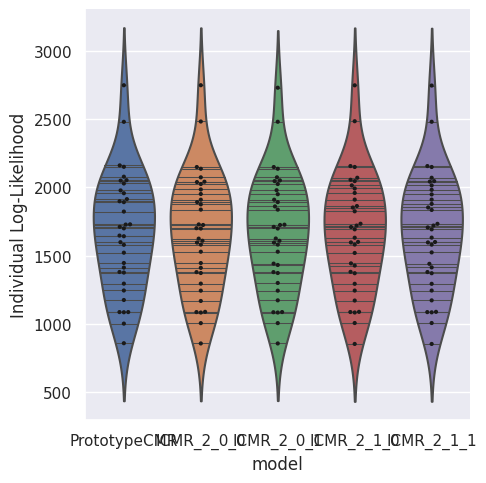

In [6]:
#| code-summary: code -- 3) plot distribution of log-likelihoods across individual subjects

plt.style.use('default')
sns.set(style="darkgrid")

# build individual fits df concatenating results from each model
individual_fits = []
for model_index, model_class in enumerate(models):
    individual_fits.append(
        pd.read_csv(results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index])))
individual_fits = pd.concat(individual_fits, ignore_index=True)

# plot distribution of log-likelihoods across individual subjects
g = sns.catplot(x='model', y='likelihood', data=individual_fits, kind='violin', inner='stick')
sns.swarmplot(x="model", y="likelihood", data=individual_fits, color="k", size=3, ax=g.ax)
g.ax.set_ylabel('Individual Log-Likelihood')
#plt.savefig(results_path + 'individual_{}.pdf'.format(section_tag), bbox_inches="tight")

In [7]:
individual_fits

,subject,trial_count,likelihood,model,encoding_drift_rate,start_drift_rate,recall_drift_rate,shared_support,item_support,learning_rate,primacy_scale,primacy_decay,stop_probability_scale,stop_probability_growth,choice_sensitivity,delay_drift_rate,feature_sensitivity,context_sensitivity,learn_first
0,1,48,1891.357899,PrototypeCMR,0.798123,0.977743,0.931718,0.063036,1.000000e+00,0.208659,0.553725,44.032412,0.001528,0.256302,1.883059,4.938593e-01,NaN,NaN,NaN
1,2,48,1412.645149,PrototypeCMR,0.868753,0.024969,0.965059,0.032766,2.220446e-16,0.305002,21.719803,0.628644,0.022127,0.166547,0.890981,9.830417e-01,NaN,NaN,NaN
2,3,48,2160.209923,PrototypeCMR,0.840663,0.082266,0.946690,0.028403,1.000000e+00,0.314835,6.880786,57.452401,0.009493,0.136745,1.023366,9.264617e-01,NaN,NaN,NaN
3,4,48,1087.073304,PrototypeCMR,0.919006,0.007289,0.992128,0.002611,5.643857e-02,0.366473,100.000000,47.570112,0.055830,0.125027,0.489373,1.546793e-09,NaN,NaN,NaN
4,5,48,2049.012303,PrototypeCMR,0.646094,0.998356,0.891662,0.035200,1.000000e+00,0.258018,1.208496,49.495472,0.006254,0.192287,1.278988,9.223255e-01,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,33,48,1580.429243,ICMR_2_1_1,0.800396,0.438868,0.946451,0.016728,1.048671e-04,0.000076,5.023082,0.270967,0.017988,0.182770,1.000000,6.574407e-01,1.0,0.635700,True
171,34,48,1732.704630,ICMR_2_1_1,0.664265,0.317936,0.932149,0.059973,4.165098e-01,0.617693,1.072381,81.254301,0.006973,0.160226,1.000000,9.726372e-01,1.0,3.258893,True
172,35,48,1909.881130,ICMR_2_1_1,0.841991,0.373200,0.960081,1.000000,4.030544e-01,0.916514,1.176044,79.219023,0.006695,0.189650,1.000000,9.371901e-01,1.0,1.728544,True
173,36,48,1596.541391,ICMR_2_1_1,0.906666,0.998594,0.988655,0.852357,3.414073e-02,0.847851,1.118370,45.606274,0.026150,0.137159,1.000000,3.095931e-01,1.0,0.455958,True


In [8]:
#| code-summary: display markdown rendering of summary table
#| echo: false
#| input: false
#| output: asis

summary_table = pd.DataFrame(group.describe().rename(columns={'likelihood':name}).squeeze()
            for name, group in individual_fits[['model', 'likelihood']].groupby('model')).T.to_markdown()

print("""::: {{#fig-{section_tag}fits layout-nrow=2 layout-valign="center"}}

![]({results_path}individual_{section_tag}.pdf)

{summary_table}

{individual_fits_caption}
:::""".format(section_tag=section_tag, summary_table=summary_table, individual_fits_caption=figure_caption, results_path=results_path))

::: {#fig-LohnasKahana2014fits layout-nrow=2 layout-valign="center"}

![](results/individual_LohnasKahana2014.pdf)

|       |   ICMR_2_0_0 |   ICMR_2_0_1 |   ICMR_2_1_0 |   ICMR_2_1_1 |   PrototypeCMR |
|:------|-------------:|-------------:|-------------:|-------------:|---------------:|
| count |       35     |       35     |       35     |       35     |         35     |
| mean  |     1667.55  |     1667.74  |     1667.25  |     1666.42  |       1671.65  |
| std   |      427.414 |      425.588 |      427.713 |      427.134 |        428.736 |
| min   |      857.516 |      857.516 |      853.933 |      853.882 |        859.212 |
| 25%   |     1376.11  |     1376.11  |     1376.38  |     1375.63  |       1378.23  |
| 50%   |     1698.45  |     1698.54  |     1692.43  |     1692.32  |       1699.68  |
| 75%   |     1967.46  |     1963.94  |     1974.9   |     1964.75  |       1966.8   |
| max   |     2746.77  |     2728.59  |     2746.03  |     2744.47  |       2746.62  |

Distribution 

In [9]:
#| code-summary: perform t-tests on individual-level fits
#| output: false
 
from scipy.stats import ttest_rel
import itertools

for combination in itertools.combinations(pd.unique(individual_fits.model), 2):

    print(combination)
    print(ttest_rel(individual_fits[individual_fits.model == combination[0]].likelihood, individual_fits[individual_fits.model == combination[1]].likelihood, alternative='two-sided'))
    print(ttest_rel(individual_fits[individual_fits.model == combination[0]].likelihood, individual_fits[individual_fits.model == combination[1]].likelihood, alternative='less'))
    print(ttest_rel(individual_fits[individual_fits.model == combination[0]].likelihood, individual_fits[individual_fits.model == combination[1]].likelihood, alternative='greater'))
    print()

('PrototypeCMR', 'ICMR_2_0_0')
Ttest_relResult(statistic=2.6237955558099095, pvalue=0.012927363428114158)
Ttest_relResult(statistic=2.6237955558099095, pvalue=0.9935363182859429)
Ttest_relResult(statistic=2.6237955558099095, pvalue=0.006463681714057079)

('PrototypeCMR', 'ICMR_2_0_1')
Ttest_relResult(statistic=2.1324957831887854, pvalue=0.0402708467749897)
Ttest_relResult(statistic=2.1324957831887854, pvalue=0.9798645766125051)
Ttest_relResult(statistic=2.1324957831887854, pvalue=0.02013542338749485)

('PrototypeCMR', 'ICMR_2_1_0')
Ttest_relResult(statistic=2.0942125977022883, pvalue=0.04376881051376381)
Ttest_relResult(statistic=2.0942125977022883, pvalue=0.9781155947431182)
Ttest_relResult(statistic=2.0942125977022883, pvalue=0.021884405256881904)

('PrototypeCMR', 'ICMR_2_1_1')
Ttest_relResult(statistic=2.7681840327206704, pvalue=0.009058158467116927)
Ttest_relResult(statistic=2.7681840327206704, pvalue=0.9954709207664415)
Ttest_relResult(statistic=2.7681840327206704, pvalue=0.00452

In [10]:
for combination in itertools.combinations(pd.unique(individual_fits.model), 2):

    print(combination)
    print(np.mean(individual_fits[individual_fits.model == combination[0]].likelihood.values < individual_fits[individual_fits.model == combination[1]].likelihood.values), 
        np.mean(individual_fits[individual_fits.model == combination[1]].likelihood.values < individual_fits[individual_fits.model == combination[0]].likelihood.values))

    print(np.sum(individual_fits[individual_fits.model == combination[0]].likelihood.values < individual_fits[individual_fits.model == combination[1]].likelihood.values), 
        np.sum(individual_fits[individual_fits.model == combination[1]].likelihood.values < individual_fits[individual_fits.model == combination[0]].likelihood.values))

    print()

('PrototypeCMR', 'ICMR_2_0_0')
0.2571428571428571 0.7428571428571429
9 26

('PrototypeCMR', 'ICMR_2_0_1')
0.2571428571428571 0.7428571428571429
9 26

('PrototypeCMR', 'ICMR_2_1_0')
0.34285714285714286 0.6571428571428571
12 23

('PrototypeCMR', 'ICMR_2_1_1')
0.2571428571428571 0.7428571428571429
9 26

('ICMR_2_0_0', 'ICMR_2_0_1')
0.5714285714285714 0.42857142857142855
20 15

('ICMR_2_0_0', 'ICMR_2_1_0')
0.5714285714285714 0.42857142857142855
20

 15

('ICMR_2_0_0', 'ICMR_2_1_1')
0.45714285714285713 0.5428571428571428
16 19

('ICMR_2_0_1', 'ICMR_2_1_0')
0.6 0.4
21 14

('ICMR_2_0_1', 'ICMR_2_1_1')
0.45714285714285713 0.5428571428571428
16 19

('ICMR_2_1_0', 'ICMR_2_1_1')
0.37142857142857144 0.6285714285714286
13 22



In [11]:
def model_weights(positive_log_likelihoods, number_parameters, N):
    AIC = 2 * positive_log_likelihoods + 2 * number_parameters
    AICc = AIC #+ (2*np.power(number_parameters, 2) + 2 * number_parameters) / (N - number_parameters - 2)
    AICd = AIC - np.min(AICc)
    #return AICd
    AICw = np.exp(-.5 * AICd) / np.sum(np.exp(-.5 * AICd))
    return AICw

aicw = {'Model': [], 'Subject': [], 'AICw': []}

total_nlns = np.zeros(len(models))
for subject_index, subject in enumerate(pd.unique(events.subject)):

    subject_specific_trial_mask = np.logical_and(
                    generate_trial_mask(events, f'subject == {subject}'), trial_mask)

    nlnLs = []
    for model_index, model_class in enumerate(models):
        nlnLs.append(
            individual_fits[individual_fits.model == model_names[model_index]].likelihood.values[subject_index])
    nlnLs = np.array(nlnLs)
    total_nlns += nlnLs
    
    weights = model_weights(nlnLs, len(free_parameters[model_index]), np.sum(subject_specific_trial_mask))
    #print(weights)
    for model_index, model_class in enumerate(models):
        aicw['Model'].append(model_names[model_index])
        aicw['Subject'].append(subject)
        aicw['AICw'].append(weights[model_index])

aicw = pd.DataFrame(data=aicw)
total_aicw = model_weights(total_nlns, len(free_parameters[model_index]), np.sum(trial_mask))
print(total_aicw)

[3.65243217e-80 6.67130278e-18 8.63825651e-21 2.62530007e-13
 1.00000000e+00]


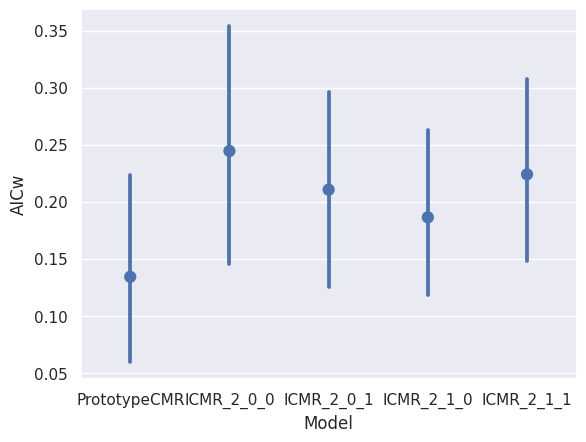

In [12]:
import seaborn as sns
sns.set_theme(style="darkgrid")
x = sns.pointplot(x="Model", y="AICw", data=aicw, join=False)

plt.show()

In [13]:
from compmemlearn.datasets import find_first

In [14]:
def simulate_df_from_events(model_class, parameters, events, trial_mask, experiment_count, first_recall_item=None):

    trials, list_lengths, presentations = events_metadata(events)
    chose = [i for i in range(len(trial_mask)) if np.sum(trial_mask[i]) != 0]
    assert(len(chose) == 1)
    chose = chose[0]
    trial_mask = trial_mask[chose]
    trials = trials[chose][trial_mask]
    presentations = presentations[chose][trial_mask]

    default_columns = ['subject', 'list', 'trial_type', 'item', 'input', 'output', 'study', 'recall', 'repeat', 'intrusion', 'first_input']
    extra_columns = [each for each in events.columns if each not in default_columns]

    labels = {}
    for column in extra_columns:
        try:
            labels[column] = (
                events.pivot_table(index=['subject', 'list'], dropna=False)[column].values)

            if 'list length' in events.columns:
                trial_details = events.pivot_table(index=['subject', 'list'], dropna=False).reset_index()
                list_length_mask = trial_details.eval(trial_query).to_numpy(dtype='bool')
                labels[column] = labels[column][list_length_mask]
            else:
                labels[column] = labels[column][trial_mask]
        except KeyError:
            pass

    data = []
    for experiment in range(experiment_count):
        for trial_index in range(len(presentations)):
        
            # retrieve presentation sequence for this trial and measure number of unique items
            presentation = presentations[trial_index]
            item_count = np.max(presentation)+1

            # record presentation events
            for presentation_index, presentation_event in enumerate(presentation):
                data.append([
                    experiment, trial_index, 'study', presentation_index+1, presentation_event, presentation_index+1])
                for label in labels:
                    data[-1].append(labels[label][trial_index])

            # simulate recall and identify first study position of each recalled item
            model = model_class(item_count, len(presentation), parameters)
            model.experience(model.items[presentation])
            if first_recall_item is not None:
                model.force_recall(first_recall_item)
            recalled = model.free_recall()
            trial = [find_first(recalled[i], presentation) + 1 for i in range(len(recalled))]

            # record recall events
            for recall_index, recall_event in enumerate(trial):
                if recall_event != 0:
                    data.append([
                        experiment, trial_index, 'recall', recall_index+1, 
                        presentation[recall_event-1], recall_event])
                    for label in labels:
                        data[-1].append(labels[label][trial_index])

    data = pd.DataFrame(data, columns=[
        'subject', 'list', 'trial_type', 'position', 'item', 'first_input'] + list(labels.keys()))
    merged = fr.merge_free_recall(data, list_keys=['first_input'] + list(labels.keys()))
    return merged

sim_df for PrototypeCMR with tag LohnasKahana2014 and list length 40 already exists


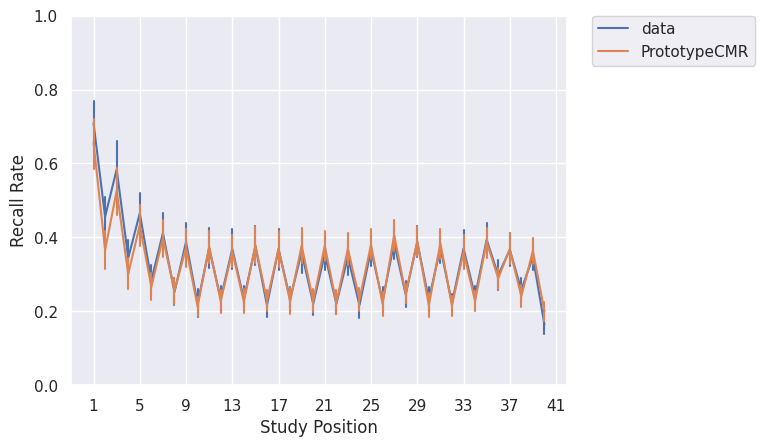

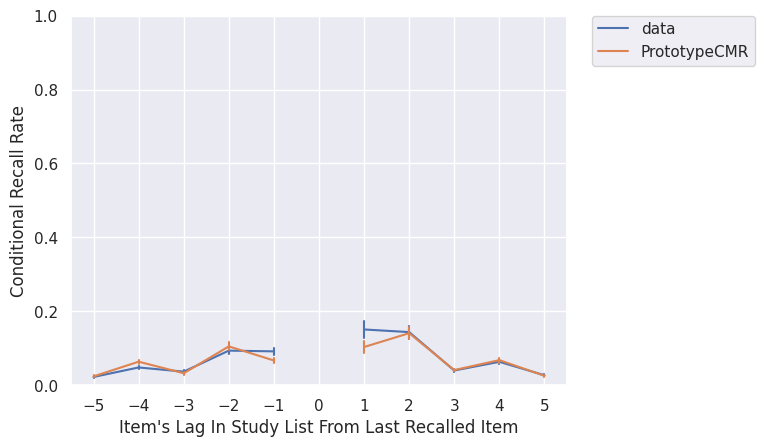

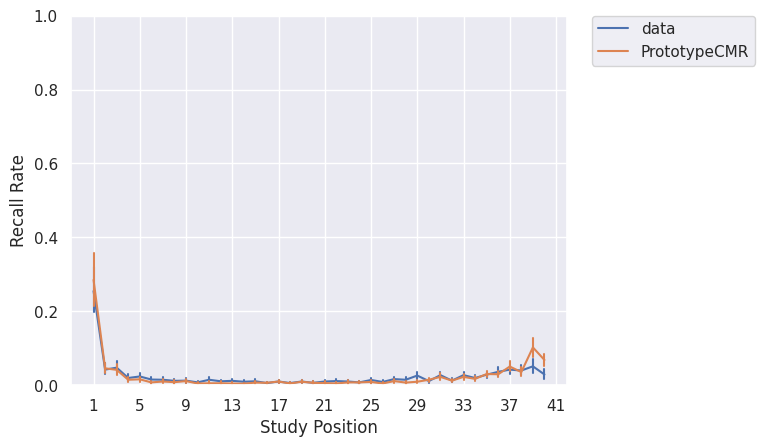

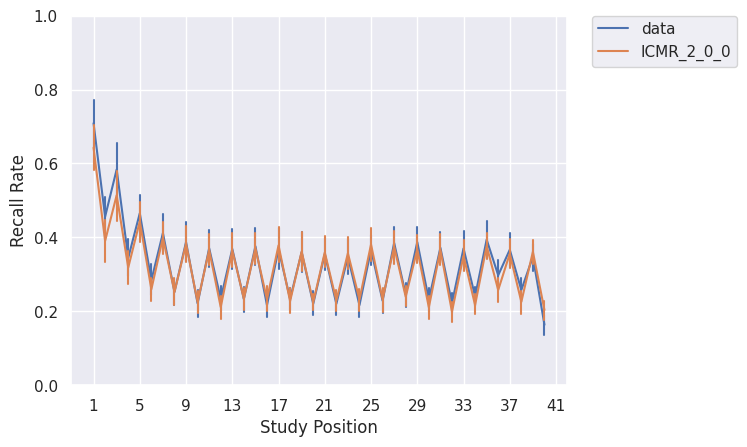

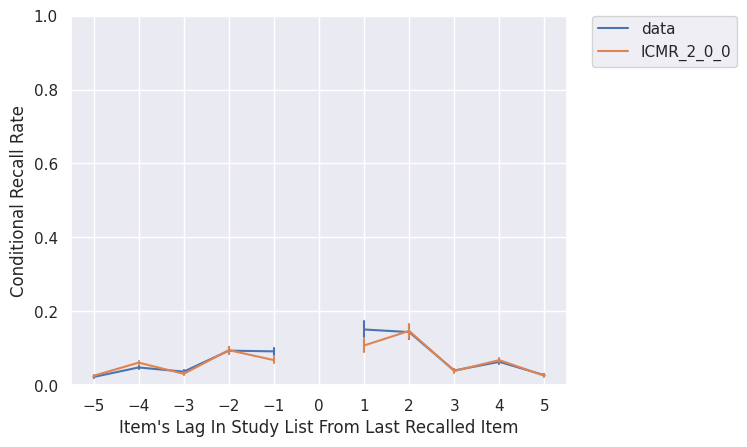

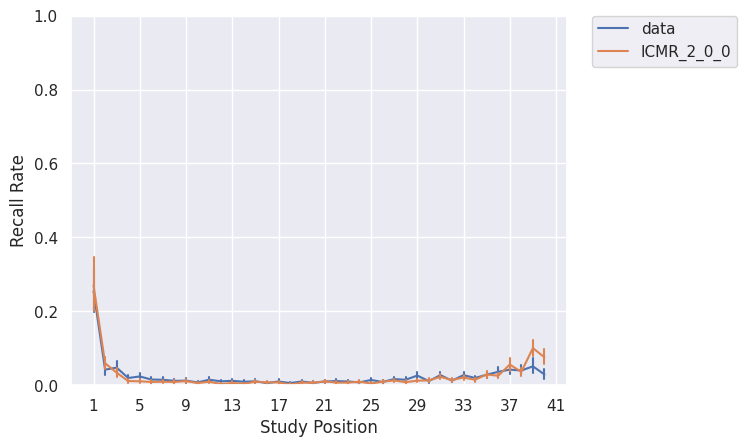

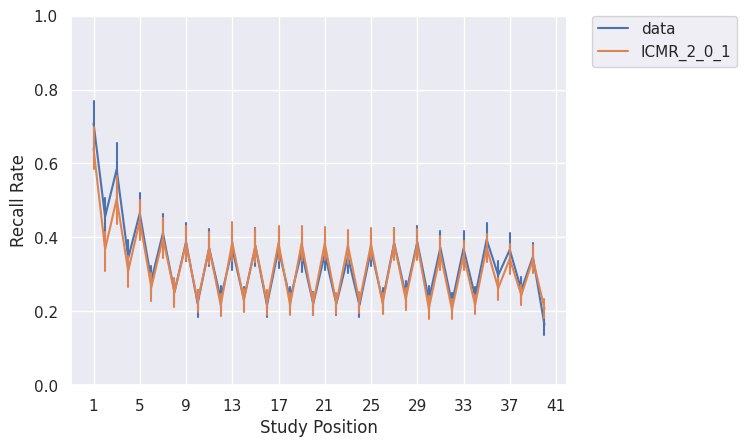

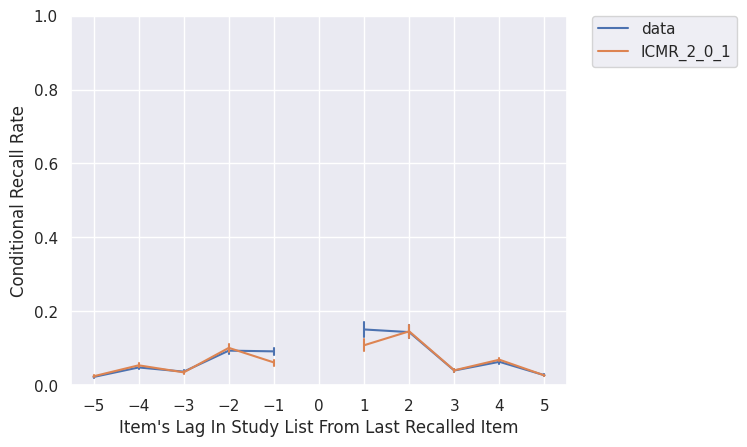

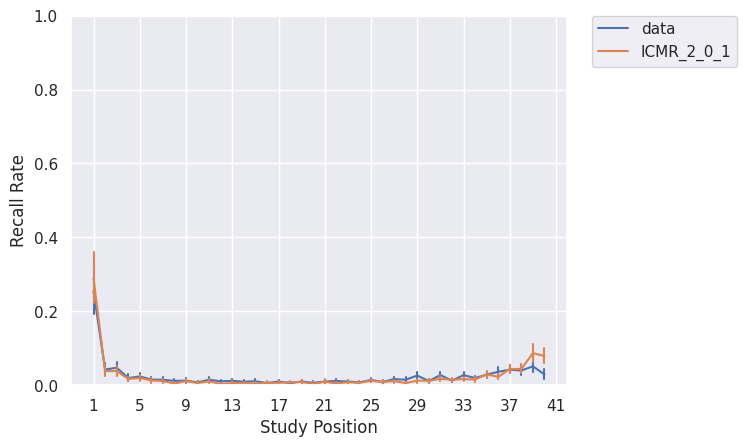

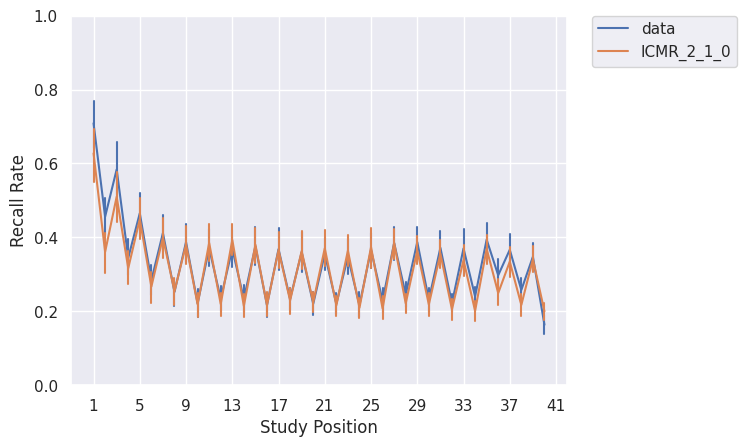

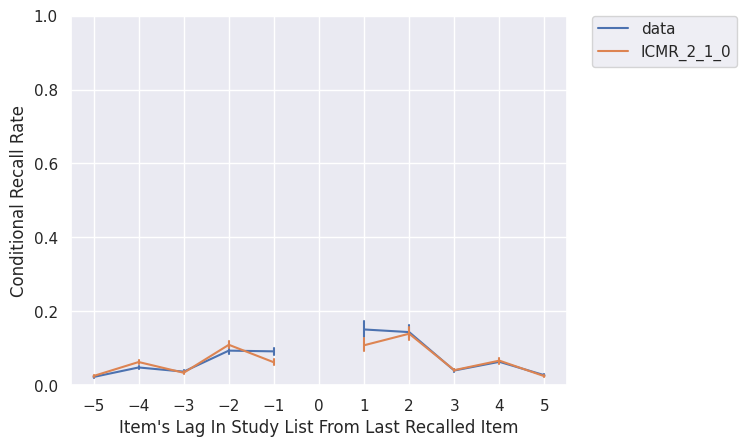

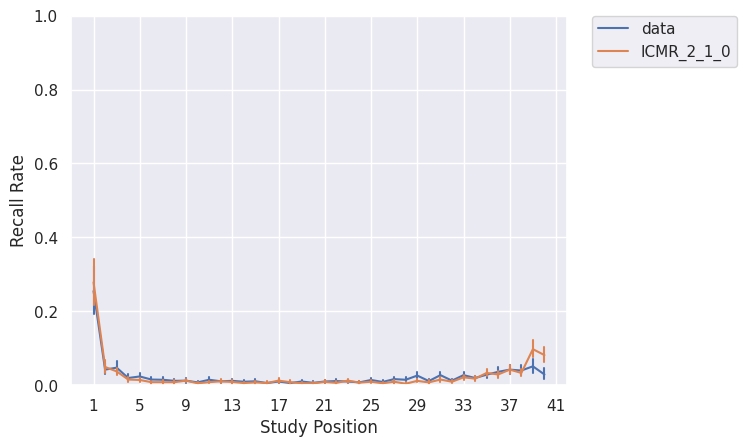

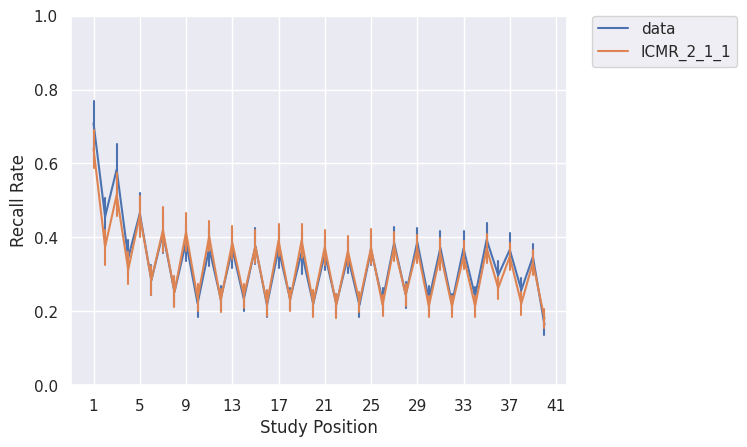

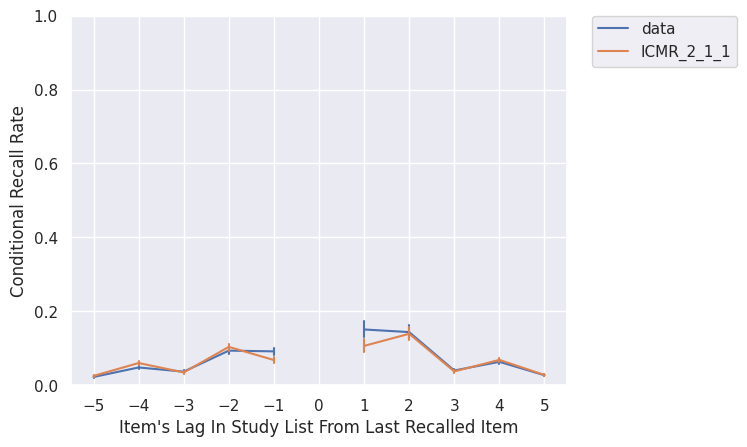

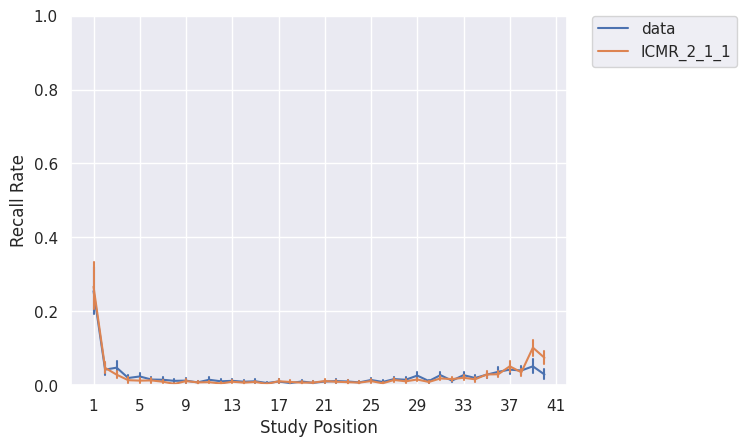

In [15]:
sns.set(style='darkgrid')

# for each unique list length
if not (isinstance(list_lengths, list) or isinstance(list_lengths, List)): 
    list_lengths = [list_lengths]

for ll_index, list_length in enumerate(list_lengths):
    
    # for each unique model
    for model_index, model_class in enumerate(models):

        # load sim_df from csv if it exists
        sim_df_path = results_path + '{}_{}_ll{}_sim_df.csv'.format(section_tag, model_names[model_index], list_length)
        if os.path.isfile(sim_df_path):
            sim_df = pd.read_csv(sim_df_path)
            print('sim_df for {} with tag {} and list length {} already exists'.format(model_names[model_index], section_tag, list_length))

        # otherwise, generate it
        else:

            @njit(fastmath=True, nogil=True)
            def init_model(item_count, presentation_count, parameters):
                return model_class(item_count, presentation_count, parameters)

            # for each unique matching entry in individual df
            sim_dfs = []
            for subject in pd.unique(individual_fits.subject):
                
                fit_result = individual_fits.query(f'subject == {subject} & model == "{model_names[model_index]}"')

                # configure model based on specified parameters
                fitted_parameters = Dict.empty(
                    key_type=types.unicode_type, value_type=types.float64
                )
                for i in range(len(free_parameters[model_index])):
                    fitted_parameters[free_parameters[model_index][i]] = fit_result[free_parameters[model_index][i]].values[0]
                for key in fixed_parameters[model_index]:
                    fitted_parameters[key] = fixed_parameters[model_index][key]

                if 'list length' in events.columns:
                    ll_specific_trial_query = trial_query + f' & subject == {subject} & `list length` == {list_length}'
                else:
                    ll_specific_trial_query = trial_query + f' & subject == {subject}'

                ll_specific_trial_mask = generate_trial_mask(events, ll_specific_trial_query)

                if np.sum(ll_specific_trial_mask) == 0:
                    continue

                # simulate df based on specified trial_count and experiment_count
                sim_dfs.append(simulate_df_from_events(
                    init_model, fitted_parameters, events, ll_specific_trial_mask, experiment_count))
                sim_dfs[-1].subject = subject

            # concatenate simulations into one dataframe
            if len(sim_dfs) == 0:
                sim_df = None
                continue
            sim_df = pd.concat(sim_dfs)

            # save sim_df to csv
            sim_df.to_csv(results_path +'{}_{}_ll{}_sim_df.csv'.format(section_tag, model_names[model_index], list_length), index=False)

        if sim_df is None:
            continue

        # design general filter for analysis df
        if len(list_lengths) > 1:
            analysis_query = trial_query + f' & `list length` == {list_length}'
        else:
            analysis_query = trial_query
            
        # generate plot for each parametrized analysis and model
        for analysis_index, analysis_function in enumerate(analyses):
            analysis_name = analysis_names[analysis_index]
            axis = analysis_function(
                [events, sim_df], analysis_query, contrast_name="source", labels=["data", model_names[model_index]])
            plt.savefig(results_path+'{}_{}_ll{}_{}.pdf'.format(section_tag, model_names[model_index], list_length, analysis_name), bbox_inches="tight")
            plt.show()